# Targeted Investigation into DEGs
Looking closer into DEGs with gene targets/genes of interest

# Phase 2 vs. Phase 2

## 0. load libraries

In [2]:
library(tidyverse) # for dplyr, stringr, ggplot
library(KEGGREST) # for KEGG pathways
library(multcompView) # for stat labels on ggplot
library(GO.db)
library(AnnotationDbi)

## 1. load CSVs

In [17]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

head(files)

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bb_cc.csv"
[2] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_bb.csv"
[3] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_cc.csv"
[4] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_hc.csv"
[5] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_wc.csv"
[6] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bh_hh.csv"

In [18]:
names(files) <- gsub("^DEG_", "", tools::file_path_sans_ext(basename(files)))
deg_list <- lapply(files, read.csv)
names(deg_list)
length(deg_list) # 34 pairwise comparisons

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_hh" "bw_ww" "cb_bb" "cb_bc"
[10] "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch" "cw_wc" "hb_bb"
[19] "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb" "wb_bw" "wb_cb"
[28] "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

[1] 33

## 2. Growth Genes

### Chitin Genes
In both vs. control there are four gene sets that are over-represented in relation to chitin (chitin binding, chitinase activity, chitin catabolic process, and polysaccharide catabolic process)

Want to pull these out, take a closer look, look at these in other comparisons against the both treatment and see if these genes are always affected

In [5]:
# read in gene ID to GO term file
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')

# expand df so every row contains one GO and one gene ID
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ";")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name) 

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0000981,GO:0000981,"DNA-binding transcription factor activity, RNA polymerase II-specific"
GO:0004750,GO:0004750,D-ribulose-phosphate 3-epimerase activity
GO:0003682,GO:0003682,chromatin binding
GO:0004062,GO:0004062,aryl sulfotransferase activity
GO:0005743,GO:0005743,mitochondrial inner membrane


In [6]:
chitinGO <- term2name[grep('chitin', term2name$name, ignore.case = TRUE),]
chitinGO

,term,name
,<chr>,<chr>
GO:0004100,GO:0004100,chitin synthase activity
GO:0004568,GO:0004568,chitinase activity
GO:0008061,GO:0008061,chitin binding


In [7]:
# pull out genes related to chitinase activity
# GO:0004568
chitin_genes <- term2gene %>%
inner_join(chitinGO, by = 'term') %>%
distinct(gene, term, name)

chitin_genes

gene,term,name
<chr>,<chr>,<chr>
LOC111109754,GO:0004100,chitin synthase activity
LOC111109745,GO:0004100,chitin synthase activity
LOC111137818,GO:0004568,chitinase activity
LOC111119842,GO:0004568,chitinase activity
LOC111119841,GO:0004568,chitinase activity
LOC111118377,GO:0004568,chitinase activity
LOC111126623,GO:0008061,chitin binding
LOC111126666,GO:0008061,chitin binding
LOC111125904,GO:0008061,chitin binding


In [22]:
head(combined.df)

,X,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
bb_cc.1,726,LOC111134671,613.020976,1.705185,1.8602511,-3.890429,1.000673e-04,0.023871608,0.123867402,1623.040284,⋯,340.657679,46.877027,18.29407,181.5113,1580.693519,112.349708,34.203014,363.075510,CC vs. BB,BB
bb_cc.2,1086,LOC111120923,146.529937,-5.243692,4.1847160,3.947822,7.886530e-05,0.020048777,0.059178297,10.266500,⋯,182.671509,8.976452,0.00000,398.6953,184.147364,39.652838,5.344221,9.499069,CC vs. BB,CC
bb_cc.3,1148,LOC111136853,86.689266,-1.963764,2.6599338,3.713204,2.046516e-04,0.040461455,0.170868504,2.799954,⋯,3.702801,15.958137,0.00000,0.0000,6.862635,17.623484,2.137688,21.109041,CC vs. BB,CC
bb_cc.4,1221,LOC111120760,103.711700,2.616076,0.9408944,-4.651563,3.294284e-06,0.001389420,0.006801697,62.532317,⋯,30.856674,90.761903,197.57595,102.8214,81.207844,44.058709,40.616079,85.491617,CC vs. BB,BB
bb_cc.5,3058,LOC111125595,123.169520,17.307451,9.1757285,-4.195594,2.721571e-05,0.008903943,0.022714995,490.925353,⋯,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,CC vs. BB,BB
bb_cc.6,3219,LOC111114504,6.398528,7.268181,7.7009243,-3.710223,2.070769e-04,0.040461455,0.119596502,0.000000,⋯,0.000000,0.000000,0.00000,0.0000,19.444132,2.202935,0.000000,0.000000,CC vs. BB,BB


In [23]:
# combining all dfs into one
combined.df <- do.call(rbind, deg_list)
dim(combined.df)

# pulling out only genes related to chitin
chitin_all <- combined.df[chitin_genes$gene %in% combined.df$Gene,]
dim(chitin_all)
head(chitin_all)

[1] 10831   107

[1] 2445  107

,X,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
bb_cc.8,3439,LOC111099906,5.155636,17.357438,3.2992027,-5.439146,5.353655e-08,3.783432e-05,8.207790e-05,0.000000,⋯,28.388140,0.00000,0.000000,0.000000,13.72527,2.202935,0.000000,0.000000,CC vs. BB,BB
bb_cc.12,7538,LOC111118721,187.898441,3.401102,3.1460882,-3.921670,8.793739e-05,2.157732e-02,9.102834e-02,7.466545,⋯,17.279737,18.95029,0.000000,6.295189,42.31958,20.927887,665.889926,1.055452,CC vs. BB,BB
bb_cc.13,7586,LOC111120415,32.372007,-1.425296,2.0304419,3.713828,2.041478e-04,4.046146e-02,1.863227e-01,2.799954,⋯,4.937068,31.91627,207.637690,229.774398,67.48257,0.000000,9.619598,13.720877,CC vs. BB,CC
bb_cc.20,8731,LOC111124056,95.248027,4.470904,3.8329754,-3.924917,8.675976e-05,2.144152e-02,7.309833e-02,421.859809,⋯,6.171335,142.62585,386.919573,122.756185,155.55305,116.755579,458.534155,226.922194,CC vs. BB,BB
bb_cc.21,9493,LOC111123476,5.497931,20.629621,3.5260204,-6.027731,1.662779e-09,1.842574e-06,1.810958e-06,2.799954,⋯,0.000000,0.00000,3.658814,20.983963,0.00000,1.101468,0.000000,0.000000,CC vs. BB,BB
bb_cc.27,11441,LOC111126100,206.790932,-1.159418,0.9352238,3.998032,6.387134e-05,1.715104e-02,8.703431e-02,167.997269,⋯,235.744988,313.17843,297.278632,165.773310,201.30395,461.514979,167.808537,329.301044,CC vs. BB,CC


there are 2445 DEGs related to chitin in all phase 2 comparisons!

In [41]:
# add col that denotes pair with Both treatment
chitin_all2 <- chitin_all %>%
mutate(pair_B = if_else(
    grepl('b', rownames(.)), 'Yes', 'No')
       )

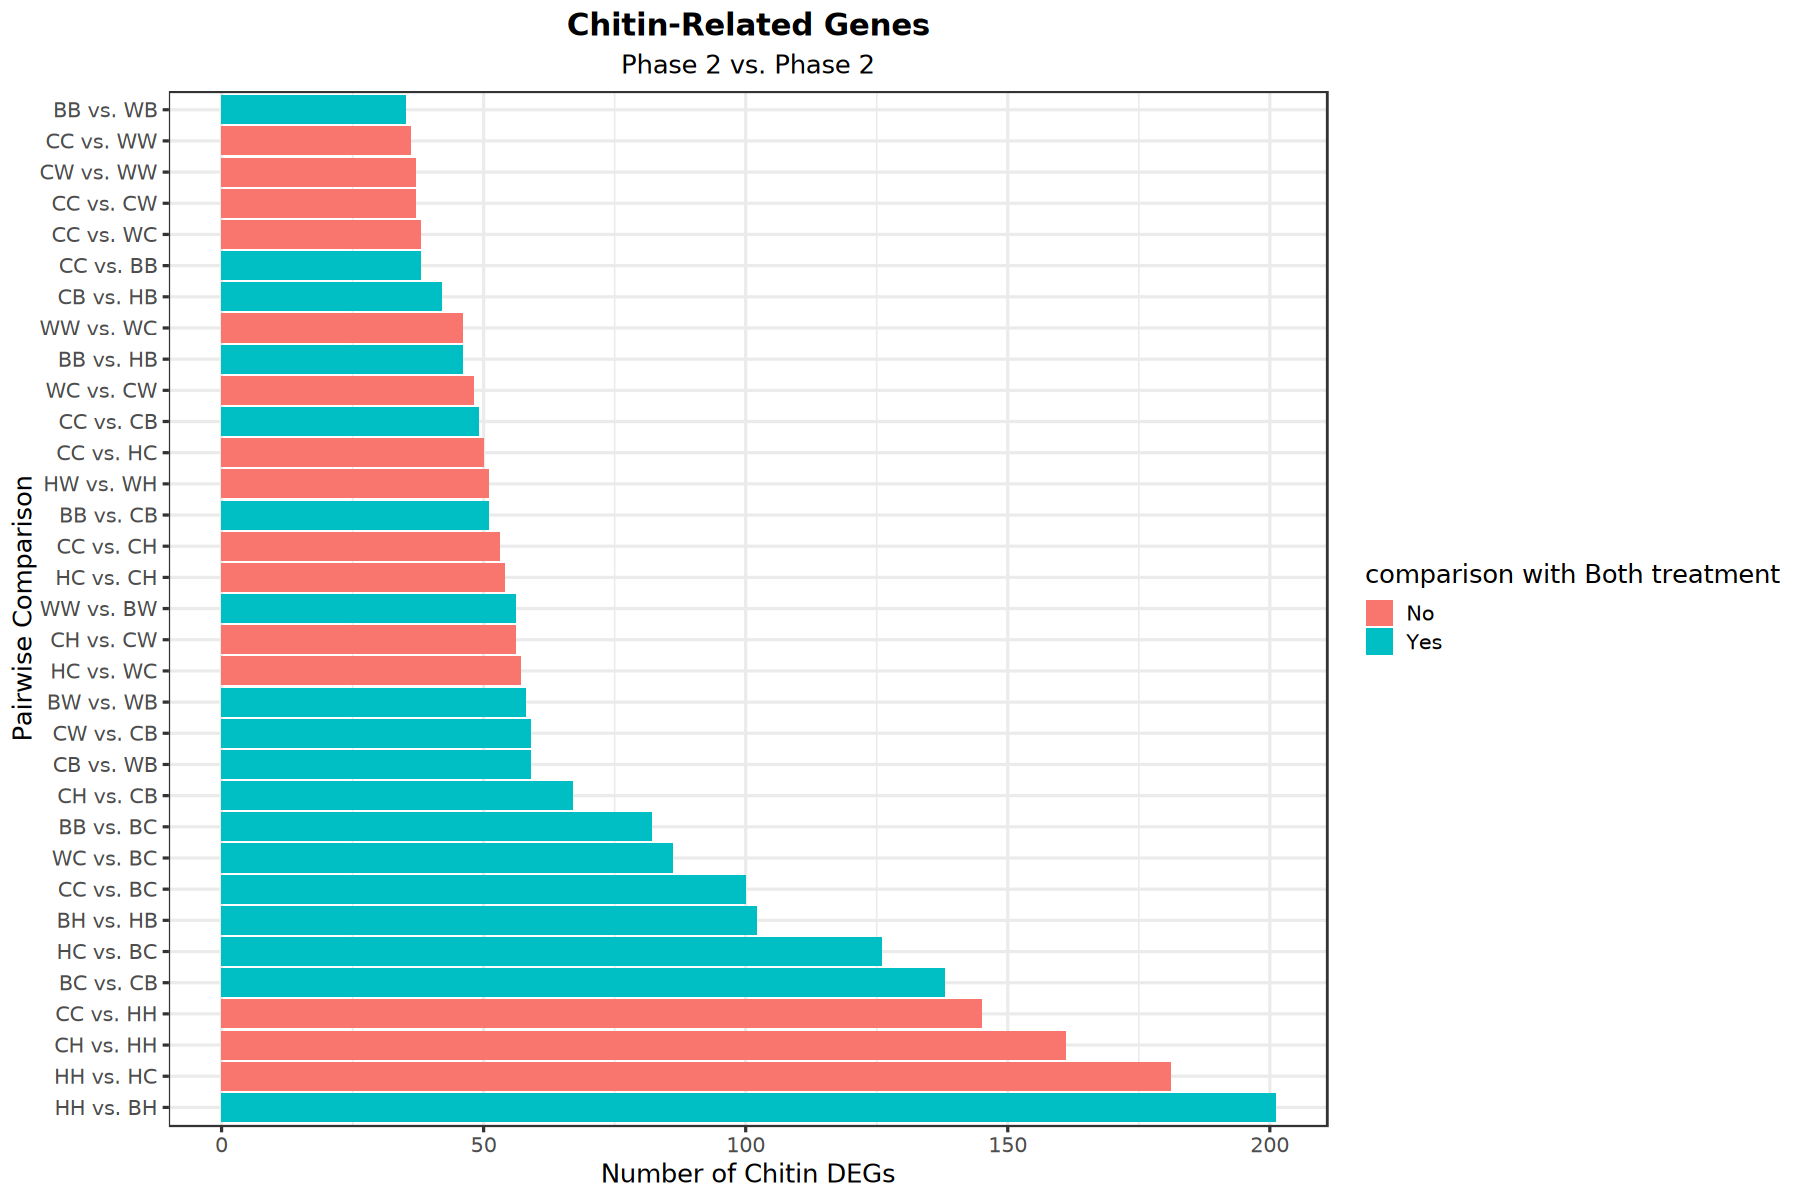

In [44]:
options(repr.plot.width=15, repr.plot.height=10)

chitin_bar <- ggplot(chitin_all2, aes(x = reorder(pair, -table(pair)[pair]), fill = pair_B)) +
geom_bar(stat = 'count') + 
#scale_fill_brewer(palette='Set2') + 
theme_bw(base_size=15) +
labs(title = 'Chitin-Related Genes',
     subtitle = 'Phase 2 vs. Phase 2',
     x = 'Pairwise Comparison',
     y = 'Number of Chitin DEGs',
    fill = 'comparison with Both treatment') +
theme(plot.title = element_text(face = 'bold', hjust = 0.5),
     plot.subtitle = element_text(hjust = 0.5)) + 
coord_flip() 

chitin_bar

In [45]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/plots/chitin.genes_bar.pdf', chitin_bar, width = 15, height = 10)